In [36]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as signal
import altair as alt
import warnings

from pathlib import Path
from operator import and_
from functools import reduce
from itertools import chain, groupby, product, accumulate
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

alt.data_transformers.enable('default', max_rows=None)
warnings.filterwarnings('ignore')
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.41 ms


## Read Data

In [37]:
cols_names = [
    'acceleration, chest (X axis)',
    'acceleration, chest (Y axis)',
    'acceleration, chest (Z axis)',
    'ECG-1',
    'ECG-2',
    'acceleration, left-ankle (X axis)',
    'acceleration, left-ankle (Y axis)',
    'acceleration, left-ankle (Z axis)',
    'gyro, left-ankle (X axis)',
    'gyro, left-ankle (Y axis)',
    'gyro, left-ankle (Z axis)',
    'magnetometer, left-ankle (X axis)',
    'magnetometer, left-ankle (Y axis)',
    'magnetometer, left-ankle (Z axis)',
    'acceleration, right-lower-arm (X axis)',
    'acceleration, right-lower-arm (Y axis)',
    'acceleration, right-lower-arm (Z axis)',
    'gyro, right-lower-arm (X axis)',
    'gyro, right-lower-arm (Y axis)',
    'gyro, right-lower-arm (Z axis)',
    'magnetometer, right-lower-arm (X axis)',
    'magnetometer, right-lower-arm (Y axis)',
    'magnetometer, right-lower-arm (Z axis)',
    'activity'
]

time: 319 µs


In [38]:
activities_names = np.array([
    'N/A',
    'Standing still',
    'Sitting and relaxing',
    'Lying down',
    'Walking',
    'Climbing stairs',
    'Waist bends forward',
    'Frontal elevation of arms',
    'Knees bending (crouching)',
    'Cycling',
    'Jogging',
    'Running',
    'Jump front & back',
])

time: 291 µs


In [39]:
fs = 50

time: 236 µs


In [40]:
partial_dfs = []
for i in range(1, 11):
    partial_df = pd.read_table(Path('data')/ ('mHealth_subject' + str(i) + '.log'), header=None, names=cols_names)
    partial_df['timepoint'] =  np.arange(1/fs*len(partial_df), step=1/fs)[:len(partial_df)]
    partial_df['subject'] = i
    partial_dfs.append(partial_df)
    
df = pd.concat(partial_dfs)

time: 4.17 s


## Data Exploration

In [41]:
df.head()

,"acceleration, chest (X axis)","acceleration, chest (Y axis)","acceleration, chest (Z axis)",ECG-1,ECG-2,"acceleration, left-ankle (X axis)","acceleration, left-ankle (Y axis)","acceleration, left-ankle (Z axis)","gyro, left-ankle (X axis)","gyro, left-ankle (Y axis)",...,"acceleration, right-lower-arm (Z axis)","gyro, right-lower-arm (X axis)","gyro, right-lower-arm (Y axis)","gyro, right-lower-arm (Z axis)","magnetometer, right-lower-arm (X axis)","magnetometer, right-lower-arm (Y axis)","magnetometer, right-lower-arm (Z axis)",activity,timepoint,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,0.187760,-0.44902,-1.0103,0.034483,-2.35000,-1.610200,-0.030899,0,0.00,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,0.02,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,0.04,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,0.06,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,0.08,1


time: 27.7 ms


In [42]:
df['activity'] = activities_names[df['activity']]

time: 304 ms


In [43]:
def get_activity_intervals_df(df):
    activity_intervals = []
    for i in df.groupby('subject'):
        prev = None
        timepoints = []
        activities = []

        for ind, val in enumerate(i[1]['activity']):
            if val != prev:
                prev = val
                timepoints.append(df.iloc[ind]['timepoint'])
                activities.append(val)
        timepoints.append(i[1].iloc[-1]['timepoint'])

        activity_df = pd.DataFrame({
            "start": pd.to_datetime(timepoints[:-1], unit='s'), 
            "end": pd.to_datetime(timepoints[1:], unit='s'), 
            'activity': activities,
            'subject': i[0]
        })
        activity_df['length'] = (activity_df['end'] - activity_df['start'])/ np.timedelta64(1, 's') 
        activity_intervals.append(activity_df)
    return pd.concat(activity_intervals)

time: 580 µs


In [44]:
activity_length_df = get_activity_intervals_df(df)

time: 736 ms


In [45]:
alt.Chart(activity_length_df).mark_rule().encode(
    y = alt.Y('activity:N'),
    x = alt.X('start:T', axis=alt.Axis(title='time, mm:ss', format =('%M:%S'))),
    x2 = alt.X2('end:T')
).properties(
    width = 700/2,
    height= 300
).facet(
    facet='subject:Q', 
    columns=2
)

alt.FacetChart(...)

time: 21.5 ms


We can see, that even though we nearly 1 hour of recording, we have nearly 12 minutes of usefull signals

In [46]:
alt.Chart(activity_length_df[activity_length_df['activity'] != activities_names[0]]).encode(
    x = 'length:Q',
    y = alt.Y('activity:N', title='length, s'),
).mark_bar().facet(facet='subject:N', columns=2)

alt.FacetChart(...)

time: 31.2 ms


Jump front & back is much shorter, then previous ones (20s vs 1m), so I decided to drop it. Also, subject #7 has much shorter Climbing stairs activity (only 15 seconds), so we can drop it to use larger window size.

In [47]:
def get_signal(subject, activity):
    def get_interval():
        tmp_df = activity_length_df[activity_length_df['subject'] == subject]
        res = tmp_df[tmp_df['activity'] == activity]
        return res['start'].values[0], res['end'].values[0]
    
    st, end = get_interval()
    to_seconds = lambda x: x.astype('float')/10**9
    get_index = lambda x: np.argmin(np.abs(df['timepoint'].values - x))
    st, end = to_seconds(st), to_seconds(end)
    
    return df.iloc[get_index(st): get_index(end)]

time: 819 µs


## Data Preprocessing

In [187]:
window_length = 20
used_signals = ['ECG-1', 'ECG-2', 'timepoint']
used_signals += [
    'acceleration, right-lower-arm (X axis)',
    'acceleration, right-lower-arm (Y axis)',
    'acceleration, right-lower-arm (Z axis)',
]
used_signals += ['subject']
activity_to_signals = defaultdict(list)
# df
# activity_length_df
for activity in activities_names:
    if activity in ['N/A']:
        continue
    tmp_df = activity_length_df[activity_length_df['activity'] == activity]
    tmp_df = tmp_df[tmp_df['length'] > window_length]
    to_seconds = lambda x: x.astype('float')/10**9
    st = to_seconds(tmp_df['start'].values)
    end = to_seconds(tmp_df['end'].values)
    for st, en, subject in zip(st, end, tmp_df['subject'].values):
        length = (en-st) - ((en-st) % window_length)
        tmp_df = df[df['subject'] == subject]
        tmp_df = tmp_df[tmp_df['timepoint'] >= st]
        tmp_df = tmp_df[tmp_df['timepoint'] < st + length]
        
        if len(tmp_df) != 0:
            activity_to_signals[activity].append(tmp_df[used_signals])

time: 2.23 s


In [188]:
signal_activity_pairs = []
for activity in activity_to_signals.keys():
    for signal_per_subject in activity_to_signals[activity]:
        for i in range(int(len(signal_per_subject)/(fs*window_length))):
            signal_activity_pairs.append((signal_per_subject.iloc[i*window_length*fs:(i+1)*window_length*fs], activity))

time: 40 ms


## Feature generating

In [189]:
def plot_ecg(sig,lead=1, rs=None):
    base = alt.Chart(sig).mark_line().encode(
        x = alt.X('timepoint:Q', axis=alt.Axis(labels=True), title='time, s'),
        y = alt.Y('ECG-'+str(lead)+':Q', title='Voltage, mV'),
    )
    
    if rs is None:
        return base
    
    return alt.layer(
        base,
        alt.Chart(pd.DataFrame({'label_time': rs})).mark_rule().encode(
            x = alt.X(field='label_time', type='quantitative', axis=alt.Axis(labels=False), title=''),
            color=alt.value('#ae1325')
        ),    
    )

def plot_series(sig, stem=False):
    df = pd.DataFrame(data=sig, index=sig.index).reset_index()
    base  = alt.Chart(df).encode(
        x = alt.X('timepoint:Q', axis=alt.Axis(labels=True), title='time, s', scale=alt.Scale(zero=False)),
        y = alt.Y('ECG-1:Q', title='Voltage, mV'),
    )
    if stem:
        return base.mark_rule() + base.mark_point()
    else:
        return base.mark_line()

time: 1.14 ms


In [190]:
#reduce(and_, [plot_ecg(get_signal(1, activity)).properties(title=activity) for activity in activities_names[1:]])

time: 258 µs


In [191]:
def get_rs(sig, show_step_visualization=False, lead=1):
    ecg_sig = sig['ECG-' + str(lead)]
    ecg_sig = ecg_sig.set_axis(sig['timepoint'], axis='index')

    d1 = ecg_sig.shift(1) - ecg_sig
    d2 = d1.shift(1) - d1
    d = d2**2
    d = d[d.notnull()]


    treshhold = max(d)*0.03
    picks = d[d > treshhold]

    after_threshold = picks.copy(deep=True)

    for i in picks.index:
        siblings = picks[np.abs(picks.index - i) < 0.075]
        if picks[i] != 0:
            for s in siblings.index:
                if s == i:
                    continue
                picks[s] = 0
    picks = picks[picks != 0]

    rs = []
    for qrs_region_center in picks.index:
        region = ecg_sig[np.abs(ecg_sig.index - qrs_region_center) < 0.075]
        mn = (min(region) + max(region))/2
        r = region[(region-mn) == (region - mn).max()].index[0]
        if not len(rs) or ((r - rs[-1]) != 0):
            rs.append(r)
    
    if show_step_visualization:
        return plot_series(d).properties(title='Double Difference array') & \
        plot_series(after_threshold, stem=True).properties(title='Applied 3 % threshold') & \
        plot_series(picks, stem=True).properties(title='Remove in 75 ms neigbours') & \
        plot_ecg(sig, rs=rs).properties(title='With R labels')
    else:
        return np.array(rs)

time: 893 µs


In [192]:
def get_rr_intervals(r_locations):
    return r_locations[1:] - r_locations[:-1]

def get_nn50(rr_intervals):
    max_strike = 0
    cur_strike = 0
    prev_val = 0
    for i in rr_intervals:
        if i - prev_val < 0.05:
            cur_strike += 1
        else:
            if cur_strike > max_strike:
                max_strike = cur_strike
            cur_strike = 0
        prev_val = i
    if cur_strike > max_strike:
        max_strike = cur_strike
    return max_strike

def get_sssp_features(data, positive=False):
    res = [
        np.mean(data),
        np.median(data),
        np.std(data),
        stats.trim_mean(rr_intervals, 0.25),
        stats.skew(data),
        stats.kurtosis(data),
        np.max(data),
        np.min(data),
        stats.scoreatpercentile(data, 25),
        stats.scoreatpercentile(data, 75),
    ]
    if positive:
        res.extend([
            stats.gmean(data),
            stats.hmean(data),
            stats.gstd(data)
        ])
    return res


def get_time_domain_features(rr_intervals):
    # deep breathing difference
    dbd = max(rr_intervals) - min(rr_intervals)
    # the number of successive RR interval pairs differing by more than 50 ms
    nn50 = get_nn50(rr_intervals)
    # nn50 normalized by 
    pnn50 = get_nn50(rr_intervals)/len(rr_intervals)
    # root mean square of successive differences
    rmssd = np.sum((rr_intervals[1:] - rr_intervals[:-1])**2)
    return dbd, nn50, pnn50, rmssd

time: 789 µs


In [193]:
def get_hr_features(rr_intervals, show_visualization=False):
    timepoints = np.array(list(accumulate(rr_intervals)))
    hrv = np.interp(x=np.linspace(timepoints[0], timepoints[-1], 256), xp=timepoints, fp=rr_intervals)

    fourier = np.fft.fft(hrv)[:hrv.size//2]
    frequencies = np.fft.fftfreq(hrv.size, d=1/256)[:hrv.size//2]

    f, Pxx_den = signal.periodogram(hrv, 256)

    top_6_psd_from_hrv = list(map(lambda x: x[0], sorted(list(zip(f, Pxx_den)), key=lambda x: x[1], reverse=True)[:6]))

    if show_visualization:
        return (
            alt.Chart(pd.DataFrame({'rr_interval': hrv, 'timepoint': np.arange(0, 256, 1)})).encode(
                y = alt.Y('rr_interval:Q', title="RR interval duration"),
                x = alt.X('timepoint:Q', title="time, s")
            ).mark_line().properties(title='Heart rate variability') 
        ) | \
        (
            alt.Chart(pd.DataFrame({"frequency": f, "density": Pxx_den})).encode(
                x = alt.X('frequency:Q', title='Hz'),
                y = alt.Y('density:Q', title='density, U^2/Hz',)
            ).mark_line() + alt.Chart(pd.DataFrame({'top_frequency': top_6_psd_from_hrv, 'density': Pxx_den[list(map(int, top_6_psd_from_hrv))]})).encode(
                x = 'top_frequency:Q',
                y = 'density:Q'
            ).mark_point(color='red')
        ).properties(title='Top 6 power spectral density')
    spectral_entropy = stats.entropy(Pxx_den)
    energy = np.sum(Pxx_den)*(f[1]-f[0])
    return spectral_entropy, energy, *top_6_psd_from_hrv, *get_sssp_features(hrv)

time: 889 µs


In [194]:
get_rs(sig = get_signal(1, 'Lying down')[:500], show_step_visualization=True)

alt.VConcatChart(...)

time: 174 ms


In [195]:
rr_intervals = get_rr_intervals(get_rs(sig = get_signal(1, 'Lying down')[:500]))
get_hr_features(rr_intervals, show_visualization=True)

alt.HConcatChart(...)

time: 103 ms


In [196]:
def get_ecg_features(sig, lead=1):
    rr_intervals = get_rr_intervals(get_rs(sig, lead=lead))
    # heart rate in beats per minute
    hr = 1/rr_intervals*60
    features = [
                *get_hr_features(rr_intervals),
                *get_sssp_features(rr_intervals), 
                *get_sssp_features(hr), 
                *get_time_domain_features(rr_intervals),
                ]
    return features

time: 793 µs


In [197]:
feature_names = [
    'spectral_entropy',
    'energy',
    'psd_top_1',
    'psd_top_2',
    'psd_top_3',
    'psd_top_4',
    'psd_top_5',
    'psd_top_6',
    'hrv_mean',
    'hrv_median',
    'hrv_std',
    'hrv_trim_mean',
    'hrv_skew',
    'hrv_kurtosis',
    'hrv_max',
    'hrv_min',
    'hrv_percentile_25',
    'hrv_percentile_75',
    'rr_interval_mean',
    'rr_interval_median',
    'rr_interval_std',
    'rr_interval_trim_mean',
    'rr_interval_skew',
    'rr_interval_kurtosis',
    'rr_interval_max',
    'rr_interval_min',
    'rr_interval_percentile_25',
    'rr_interval_percentile_75',
    'hr_mean',
    'hr_median',
    'hr_std',
    'hr_trim_mean',
    'hr_skew',
    'hr_kurtosis',
    'hr_max',
    'hr_min',
    'hr_percentile_25',
    'hr_percentile_75',
    'dbd',
    'nn50',
    'pnn50',
    'rmsd'
]

time: 820 µs


In [198]:
def get_filter_params(filter_ord_func, wp, ws, fs):
    params = []
    for stop in range(1, 1000):
        try:
            order, freq = filter_ord_func(wp=wp, ws=ws, gpass=3, gstop=stop, analog=False, fs=fs)
        except:
            continue
        if order < 2:
            continue
        elif order > 10:
            break
        params.append((order, freq))
    if not len(params):
        raise ValueError("cannot find params")
    return params

def evaluate_filter(orig_sig, filtered):
    return 1/orig_sig.size*np.sum((orig_sig - filtered)**2)

def get_best_filter(orig_sig, wp, ws, btype, fs, filter_ord_func, filter_func, **args):
    filter_params = get_filter_params(filter_ord_func, wp, ws, fs)
    filters = []
    for order, freq in filter_params:
        b, a = filter_func(N=order, Wn=freq, btype=btype, analog=False, output='ba', fs=fs, **args)
        res = signal.lfilter(b, a, orig_sig)
        filters.append((b, a, evaluate_filter(orig_sig, res)))
    filters.sort(key=lambda x: x[2])
    return filters[0]

time: 2.18 ms


In [199]:
def append_suffix(lst, suffix):
    return list(map(lambda x: x + suffix, lst))

time: 665 µs


In [200]:
# signal.medfilt(signal_activity_pairs[0][0]['ECG-1'])

time: 364 µs


In [201]:
plot_ecg(signal_activity_pairs[0][0])

alt.Chart(...)

time: 70.7 ms


In [202]:
for signals, activity in signal_activity_pairs:
    b, a, score = get_best_filter(signals.iloc[:, 0], 0.4, 0.6, 'highpass', fs, signal.buttord, signal.butter)
    signals.iloc[:, 0] = signal.lfilter(b, a, signals.iloc[:, 0])

Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is ze

Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is ze

Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is ze

Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is zero...check input parameters.
Warning, order is ze

In [203]:
plot_ecg(signal_activity_pairs[0][0])

alt.Chart(...)

time: 45.9 ms


In [204]:
data = []
for signals, activity in signal_activity_pairs:
    data.append(get_ecg_features(signals, lead=1) +  
#                 get_ecg_features(signals,lead=2) + 
                [activity]
               )
    
# data = pd.DataFrame(data=data, columns=append_suffix(feature_names, "_1") + append_suffix(feature_names, "_2") + ['activity'])
data = pd.DataFrame(data=data, columns=feature_names + ['activity'])

time: 28.7 s


## Feature Selection

In [205]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from matplotlib import pyplot
import seaborn as sns

time: 465 µs


In [206]:
data.head()

,spectral_entropy,energy,psd_top_1,psd_top_2,psd_top_3,psd_top_4,psd_top_5,psd_top_6,hrv_mean,hrv_median,...,hr_kurtosis,hr_max,hr_min,hr_percentile_25,hr_percentile_75,dbd,nn50,pnn50,rmsd,activity
0,1.336899,0.002723,1.0,3.0,2.0,7.0,6.0,5.0,0.786283,0.775591,...,-0.917122,88.235294,68.181818,71.428571,78.947368,0.20,11,0.440000,0.0540,Standing still
1,1.344975,0.002053,2.0,3.0,1.0,4.0,9.0,7.0,0.761719,0.757469,...,-0.289124,90.909091,69.767442,75.000000,83.333333,0.20,9,0.360000,0.0328,Standing still
2,1.660580,0.002913,1.0,2.0,4.0,7.0,3.0,10.0,0.781113,0.801436,...,-1.226527,88.235294,68.181818,73.170732,83.333333,0.20,14,0.560000,0.0320,Standing still
3,1.300891,0.003937,1.0,2.0,4.0,3.0,5.0,7.0,0.662824,0.649303,...,0.691710,103.448276,69.767442,90.909091,96.774194,0.28,15,0.500000,0.0468,Standing still
4,1.898916,0.000314,1.0,3.0,4.0,5.0,2.0,6.0,0.637702,0.639498,...,0.111917,96.774194,88.235294,93.750000,96.774194,0.06,29,0.966667,0.0056,Standing still


time: 32.5 ms


In [207]:
le = LabelEncoder()
data.iloc[:, -1] = le.fit_transform(data.iloc[:,-1]).astype('float64')

time: 1.49 ms


<AxesSubplot:>

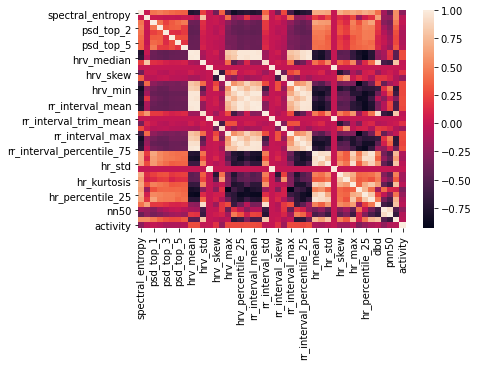

time: 371 ms


In [208]:
corr = data.corr()
sns.heatmap(data.corr())

In [209]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = data.columns[columns]
data = data[selected_columns]

time: 13.5 ms


In [210]:
data

,spectral_entropy,energy,psd_top_1,psd_top_2,psd_top_3,psd_top_4,psd_top_5,psd_top_6,hrv_mean,hrv_std,...,hrv_kurtosis,hrv_max,hrv_min,hr_mean,hr_skew,hr_kurtosis,hr_min,nn50,rmsd,activity
0,1.336899,0.002723,1.0,3.0,2.0,7.0,6.0,5.0,0.786283,0.052180,...,-1.143985,0.878952,0.680941,76.836012,0.253309,-0.917122,68.181818,11,0.0540,9.0
1,1.344975,0.002053,2.0,3.0,1.0,4.0,9.0,7.0,0.761719,0.045309,...,-0.410563,0.859694,0.660128,79.342048,0.256018,-0.289124,69.767442,9,0.0328,9.0
2,1.660580,0.002913,1.0,2.0,4.0,7.0,3.0,10.0,0.781113,0.053975,...,-1.058789,0.880000,0.681253,77.504332,0.172949,-1.226527,68.181818,14,0.0320,9.0
3,1.300891,0.003937,1.0,2.0,4.0,3.0,5.0,7.0,0.662824,0.062744,...,0.901045,0.858315,0.580000,91.997336,-0.808020,0.691710,69.767442,15,0.0468,9.0
4,1.898916,0.000314,1.0,3.0,4.0,5.0,2.0,6.0,0.637702,0.017731,...,0.448449,0.680000,0.620000,94.218813,-0.925703,0.111917,88.235294,29,0.0056,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,3.022926,0.004346,1.0,2.0,4.0,3.0,18.0,5.0,0.493729,0.065927,...,6.346262,0.620000,0.146824,133.390439,5.016482,26.031660,96.774194,28,0.5852,4.0
316,2.716384,0.000067,1.0,2.0,15.0,3.0,21.0,4.0,0.417260,0.008190,...,0.618012,0.438992,0.400000,143.962421,0.412368,0.269110,136.363636,46,0.0092,4.0
317,3.387975,0.008244,12.0,19.0,5.0,7.0,2.0,23.0,0.245244,0.090799,...,-0.325460,0.537647,0.042745,347.185787,2.543719,10.518784,107.142857,5,2.1220,4.0
318,3.138832,0.015704,3.0,4.0,11.0,8.0,7.0,18.0,0.304503,0.125315,...,-1.216841,0.550756,0.040490,386.491455,3.662824,16.136172,107.142857,7,2.7560,4.0


time: 29.2 ms


In [211]:
ecg_features_df = data.copy()

time: 528 µs


In [212]:
X = data.drop(columns=['activity'])
y = data['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

time: 6.09 ms


## Classification

In [213]:
kf = KFold(5, random_state=42, shuffle=True)
accuracies = []
for train_idx, val_idx in kf.split(X_train, y_train):
    X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # A parameter grid for XGBoost
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'max_depth': [3, 4, 5],
            }

    model = XGBClassifier()
    clf = GridSearchCV(model, params, n_jobs=5, 
                   cv=StratifiedKFold(), 
                   verbose=0, refit=True)

    clf.fit(X_cur_train, y_cur_train)
    y_pred = clf.predict(X_val)
    top_features = list(map(lambda x: x[1], sorted(zip(clf.best_estimator_.feature_importances_, range(0,data.shape[1])), key=lambda x: x[0], reverse=True)))
    top_all_features = top_features
    accuracies.append(accuracy_score(y_pred, y_val))

print("CV score: {:.2f}".format(np.mean(accuracies)))

CV score: 0.34
time: 1min 20s


In [214]:
best = 0, None, 0
scores = []
for i in range(28, 10, -2):
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        model = XGBClassifier()
        clf = GridSearchCV(model, params, n_jobs=5, 
                       cv=StratifiedKFold(random_state=42, shuffle=True), 
                       verbose=0, refit=True)

        cur_top_features = top_features
        clf.fit(X_cur_train.iloc[:, cur_top_features[:i]], y_cur_train)
        y_pred = clf.predict(X_val.iloc[:, cur_top_features[:i]])
        top_features = list(map(lambda x: x[1], sorted(zip(clf.best_estimator_.feature_importances_, range(0,data.shape[1])), key=lambda x: x[0], reverse=True)))
        local_score = accuracy_score(y_pred, y_val)
        cv_scores.append(local_score)
        
    score = np.mean(cv_scores)
    scores.append(score)
    print("Score:", score)
    if score > best[0]:
         best = score, clf, cur_top_features[:i]

Score: 0.31583710407239823
Score: 0.3355957767722474
Score: 0.2964555052790347
Score: 0.31606334841628964
Score: 0.32006033182503774
Score: 0.3197586726998492
Score: 0.32360482654600303
Score: 0.3274509803921569
Score: 0.32413273001508297
time: 10min 17s


In [215]:
X_train

,spectral_entropy,energy,psd_top_1,psd_top_2,psd_top_3,psd_top_4,psd_top_5,psd_top_6,hrv_mean,hrv_std,...,hrv_skew,hrv_kurtosis,hrv_max,hrv_min,hr_mean,hr_skew,hr_kurtosis,hr_min,nn50,rmsd
271,3.252775,0.015959,3.0,12.0,1.0,2.0,6.0,8.0,0.274517,0.126328,...,0.278498,-0.620440,0.538879,0.020000,559.147421,2.424142,5.665485,111.111111,6,2.9104
273,1.211889,0.504708,1.0,2.0,3.0,6.0,4.0,9.0,0.828943,0.710428,...,0.882168,-0.862841,2.139973,0.047111,439.314165,2.304229,5.443740,28.037383,10,9.0736
294,3.758081,0.006429,17.0,25.0,51.0,7.0,5.0,12.0,0.195657,0.080179,...,0.714264,0.418981,0.453453,0.041849,570.028527,3.003411,9.099329,130.434783,6,2.7692
270,2.757502,0.000059,1.0,17.0,10.0,13.0,2.0,12.0,0.488549,0.007659,...,0.253625,-1.485717,0.500000,0.480000,122.875000,-0.303433,-1.907928,120.000000,39,0.0092
78,1.413987,0.032104,3.0,1.0,2.0,6.0,4.0,5.0,0.926432,0.179177,...,0.662828,-0.780162,1.319269,0.681423,69.961609,-0.737313,-0.330794,45.454545,5,1.1592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,2.866202,0.022443,4.0,3.0,9.0,11.0,6.0,13.0,0.350868,0.149810,...,0.587306,0.630380,0.845626,0.040000,376.450364,3.914292,15.823912,69.767442,6,2.5336
148,2.335301,0.025840,6.0,12.0,5.0,7.0,11.0,1.0,0.469417,0.160750,...,-1.056358,-0.181962,0.678097,0.061667,298.045743,1.910486,3.290850,88.235294,6,2.2156
43,1.693744,0.001690,2.0,6.0,1.0,8.0,5.0,3.0,0.878423,0.041115,...,-0.206621,-1.102256,0.956907,0.800000,68.471524,0.216525,-1.324415,62.500000,5,0.0924
17,1.544959,0.001061,1.0,2.0,4.0,5.0,8.0,3.0,0.886935,0.032567,...,0.424882,-0.918929,0.959456,0.840000,67.918872,-0.278141,-1.017337,62.500000,17,0.0216


time: 23.5 ms


In [216]:
def show_result(y_pred, y_test):
    predicted = le.inverse_transform(y_pred.astype('int'))
    test = le.inverse_transform(y_test.astype('int'))
    sns.barplot(y='activity', x='correct', data=pd.DataFrame({
        'activity': test,
        'correct': predicted == test,
    }))

    return alt.Chart(pd.DataFrame({
        "predicted": predicted,
        "correct": test
    })).mark_bar().encode(
        x='count(predicted)',
        y='predicted:N',
    ).properties(
        width=170,
        height=180
    ).facet(facet='correct:N', columns=4)

time: 493 µs


Score: 0.34


alt.FacetChart(...)

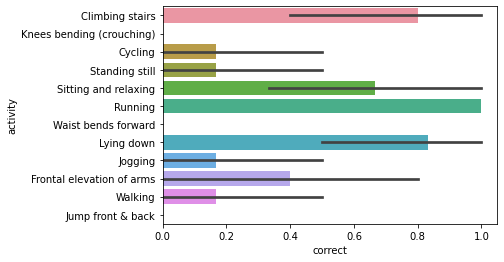

time: 490 ms


In [217]:
model = best[1].best_estimator_
y_pred = model.predict(X_test.iloc[:, best[2]])
print("Score: {:.2f}".format(best[0]))
show_result(y_pred, y_test)

Score: 0.36


alt.FacetChart(...)

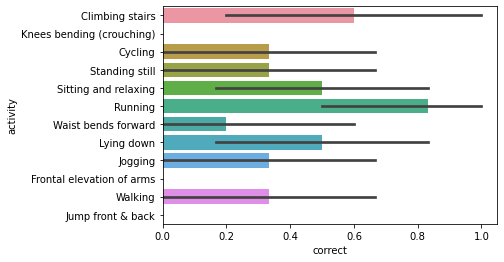

time: 19min 17s


In [218]:
params = {
            'C': np.arange(0.25, 14, 0.25),
            'kernel': ['poly', 'rbf', 'linear'],
            'degree': np.arange(1, 6, 1)
        }

model = SVC()
clf = GridSearchCV(model, params, n_jobs=5, 
               cv=StratifiedKFold(random_state=42, shuffle=True), 
               verbose=0, refit=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print("Score: {:.2f}".format(score))
show_result(y_pred, y_test)

In [235]:
x = X.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

time: 8.01 ms


In [238]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(16, input_dim=21, activation='relu', activity_regularizer=l2(0.001)))
# model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', activity_regularizer=l2(0.001)))
# model.add(Dropout(0.1))
model.add(Dense(11, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

accuracies = []
for train_idx, val_idx in kf.split(X_train, y_train):
    X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model.fit(X_cur_train, y_cur_train, epochs=100, verbose=0, validation_split=0.2, callbacks=[es])
    _, acc = model.evaluate(X_val, y_val)
    accuracies.append(acc)
print("Score:", np.mean(accuracies))

Epoch 00064: early stopping
33/33 [==============================] - 0s 99us/step
Epoch 00021: early stopping
32/32 [==============================] - 0s 17us/step
Epoch 00015: early stopping
32/32 [==============================] - 0s 116us/step
Epoch 00008: early stopping
32/32 [==============================] - 0s 16us/step
Epoch 00006: early stopping
32/32 [==============================] - 0s 23us/step
Score: 0.23636363744735717
time: 1.28 s


Score: 0.20


alt.FacetChart(...)

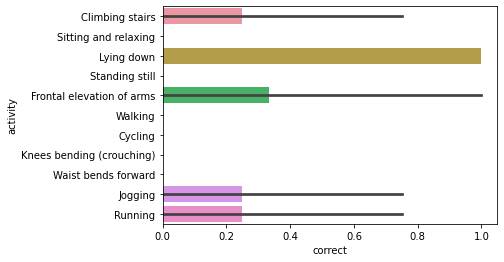

time: 502 ms


In [239]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
score = accuracy_score(y_pred, y_test)
print("Score: {:.2f}".format(score))
show_result(y_pred, y_test)

## Accelerometer

In [219]:
def get_frequency_features(sig):
    f, Pxx_den = signal.periodogram(sig, fs)
    spectral_entropy = stats.entropy(Pxx_den)
    energy = np.sum(Pxx_den)*(f[1]-f[0])
    zero_crossing_rate = 1/window_length*np.nonzero(np.diff(sig > 0))[0].size
    return spectral_entropy, zero_crossing_rate, energy

def get_accelerometer_features(sig, accel_num=1):
    accel_names = [
        'acceleration, right-lower-arm (X axis)',
        'acceleration, right-lower-arm (Y axis)',
        'acceleration, right-lower-arm (Z axis)',
    ]
    features = [
        *get_sssp_features(sig[accel_names[accel_num]]), 
        *get_frequency_features(sig[accel_names[accel_num]])
    ]
    return features

time: 608 µs


In [220]:
accel_feature_names = [
    'accel_mean',
    'accel_median',
    'accel_std',
    'accel_trim_mean',
    'accel_skew',
    'accel_kurtosis',
    'accel_max',
    'accel_min',
    'accel_percentile_25',
    'accel_percentile_75',
    'spectral_entropy',
    'zero_crossing_rate',
    'energy'
]

time: 498 µs


In [221]:
data = []
for signals, activity in signal_activity_pairs:
    data.append(get_accelerometer_features(signals, accel_num=0) +
                get_accelerometer_features(signals, accel_num=1) +
                get_accelerometer_features(signals, accel_num=2) +
                [activity]
               )
    
data = pd.DataFrame(data=data, columns=append_suffix(accel_feature_names, "_x") + \
                                                     append_suffix(accel_feature_names, "_y") + \
                                                     append_suffix(accel_feature_names, "_z") + ['activity'])

time: 2.12 s


In [222]:
data.iloc[:, -1] = le.fit_transform(data.iloc[:,-1]).astype('float64')

time: 1.24 ms


In [223]:
data

,accel_mean_x,accel_median_x,accel_std_x,accel_trim_mean_x,accel_skew_x,accel_kurtosis_x,accel_max_x,accel_min_x,accel_percentile_25_x,accel_percentile_75_x,...,accel_skew_z,accel_kurtosis_z,accel_max_z,accel_min_z,accel_percentile_25_z,accel_percentile_75_z,spectral_entropy_z,zero_crossing_rate_z,energy_z,activity
0,-2.952505,-2.954450,0.127495,0.756667,-0.012686,0.259201,-2.5602,-3.4133,-3.035075,-2.865800,...,0.004017,0.017845,2.0668,1.1815,1.589950,1.754300,5.197970,0.00,0.014778,9.0
1,-3.093715,-3.094400,0.115787,0.756667,0.074740,0.122746,-2.6500,-3.4788,-3.169725,-3.020325,...,0.068415,0.448108,2.0942,1.2808,1.591875,1.729400,5.667644,0.00,0.010817,9.0
2,-3.126496,-3.124850,0.123392,0.756667,0.102987,0.526354,-2.6697,-3.5723,-3.209725,-3.047475,...,-0.116486,0.130516,1.9810,1.2485,1.562675,1.718100,5.666816,0.00,0.012156,9.0
3,-3.109605,-3.110700,0.111266,0.756667,0.064200,-0.003423,-2.7472,-3.4421,-3.185550,-3.035025,...,-0.090081,0.124944,2.5464,1.7350,2.045100,2.199600,5.456489,0.00,0.013908,9.0
4,-3.140418,-3.142650,0.112478,0.756667,0.067109,0.094095,-2.7807,-3.5375,-3.212900,-3.067800,...,-0.090296,0.012095,2.3718,1.6531,1.947600,2.100800,5.454774,0.00,0.012591,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,-4.570970,-3.419500,9.318046,0.756667,-0.247198,-0.522530,19.1330,-21.3840,-10.133500,1.402625,...,-0.555097,1.137790,8.0144,-15.1830,-2.556775,1.640550,4.157903,7.45,12.616236,4.0
316,-1.574599,-0.765415,4.536058,0.756667,-0.854734,2.365333,15.0710,-21.8220,-3.451125,0.886005,...,1.311696,1.905384,22.5740,-6.1518,-0.786250,3.938825,3.672133,5.95,17.702425,4.0
317,-3.699596,0.649035,11.139847,0.756667,-0.497943,-1.068532,19.1180,-21.9750,-16.214500,3.987000,...,-1.244084,0.412487,14.1830,-18.2280,-4.687525,1.134775,3.499889,8.00,41.055182,4.0
318,-4.547399,-1.437400,10.343694,0.756667,-0.547723,-0.813442,18.1340,-21.9050,-11.859000,2.168475,...,1.021182,1.126801,23.9740,-11.5260,-2.113350,4.446275,3.286118,5.20,31.502233,4.0


time: 24.3 ms


<AxesSubplot:>

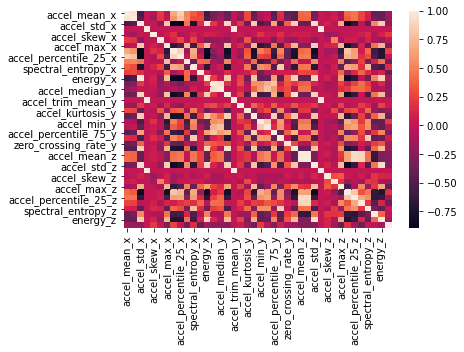

time: 404 ms


In [224]:
corr = data.corr()
sns.heatmap(data.corr())

In [225]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = data.columns[columns]
data = data[selected_columns]

time: 9.6 ms


In [226]:
data

,accel_mean_x,accel_std_x,accel_trim_mean_x,accel_skew_x,accel_kurtosis_x,accel_max_x,accel_min_x,accel_percentile_25_x,accel_percentile_75_x,spectral_entropy_x,...,spectral_entropy_y,zero_crossing_rate_y,accel_mean_z,accel_skew_z,accel_kurtosis_z,accel_max_z,accel_min_z,spectral_entropy_z,zero_crossing_rate_z,activity
0,-2.952505,0.127495,0.756667,-0.012686,0.259201,-2.5602,-3.4133,-3.035075,-2.865800,5.267958,...,5.769761,0.00,1.672682,0.004017,0.017845,2.0668,1.1815,5.197970,0.00,9.0
1,-3.093715,0.115787,0.756667,0.074740,0.122746,-2.6500,-3.4788,-3.169725,-3.020325,5.653057,...,5.807693,0.00,1.659811,0.068415,0.448108,2.0942,1.2808,5.667644,0.00,9.0
2,-3.126496,0.123392,0.756667,0.102987,0.526354,-2.6697,-3.5723,-3.209725,-3.047475,5.553384,...,5.785658,0.00,1.640060,-0.116486,0.130516,1.9810,1.2485,5.666816,0.00,9.0
3,-3.109605,0.111266,0.756667,0.064200,-0.003423,-2.7472,-3.4421,-3.185550,-3.035025,5.625648,...,5.738696,0.00,2.121415,-0.090081,0.124944,2.5464,1.7350,5.456489,0.00,9.0
4,-3.140418,0.112478,0.756667,0.067109,0.094095,-2.7807,-3.5375,-3.212900,-3.067800,5.650825,...,5.791591,0.00,2.022481,-0.090296,0.012095,2.3718,1.6531,5.454774,0.00,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,-4.570970,9.318046,0.756667,-0.247198,-0.522530,19.1330,-21.3840,-10.133500,1.402625,3.324044,...,3.350191,7.45,-0.621270,-0.555097,1.137790,8.0144,-15.1830,4.157903,7.45,4.0
316,-1.574599,4.536058,0.756667,-0.854734,2.365333,15.0710,-21.8220,-3.451125,0.886005,4.373809,...,3.209837,7.25,2.112578,1.311696,1.905384,22.5740,-6.1518,3.672133,5.95,4.0
317,-3.699596,11.139847,0.756667,-0.497943,-1.068532,19.1180,-21.9750,-16.214500,3.987000,2.626011,...,4.914910,8.20,-2.913102,-1.244084,0.412487,14.1830,-18.2280,3.499889,8.00,4.0
318,-4.547399,10.343694,0.756667,-0.547723,-0.813442,18.1340,-21.9050,-11.859000,2.168475,2.883283,...,4.027715,7.20,1.680704,1.021182,1.126801,23.9740,-11.5260,3.286118,5.20,4.0


time: 23.3 ms


In [227]:
accel_features_df = data

time: 2.65 ms


In [228]:
X = data.drop(columns=['activity'])
y = data['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

time: 4.13 ms


In [229]:
kf = KFold(5, random_state=42, shuffle=True)
accuracies = []
for train_idx, val_idx in kf.split(X_train, y_train):
    X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # A parameter grid for XGBoost
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'max_depth': [3, 4, 5],
            }

    model = XGBClassifier()
    clf = GridSearchCV(model, params, n_jobs=5, 
                   cv=StratifiedKFold(), 
                   verbose=0, refit=True)

    clf.fit(X_cur_train, y_cur_train)
    y_pred = clf.predict(X_val)
    top_features = list(map(lambda x: x[1], sorted(zip(clf.best_estimator_.feature_importances_, range(0,data.shape[1])), key=lambda x: x[0], reverse=True)))
    top_all_features = top_features
    accuracies.append(accuracy_score(y_pred, y_val))

print("CV score: {:.2f}".format(np.mean(accuracies)))

CV score: 0.85
time: 1min 20s


In [230]:
best = 0, None, 0
scores = []
for i in range(28, 10, -2):
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        model = XGBClassifier()
        clf = GridSearchCV(model, params, n_jobs=5, 
                       cv=StratifiedKFold(random_state=42, shuffle=True), 
                       verbose=0, refit=True)

        cur_top_features = top_features
        clf.fit(X_cur_train.iloc[:, cur_top_features[:i]], y_cur_train)
        y_pred = clf.predict(X_val.iloc[:, cur_top_features[:i]])
        top_features = list(map(lambda x: x[1], sorted(zip(clf.best_estimator_.feature_importances_, range(0,data.shape[1])), key=lambda x: x[0], reverse=True)))
        local_score = accuracy_score(y_pred, y_val)
        cv_scores.append(local_score)
        
    score = np.mean(cv_scores)
    scores.append(score)
    print("Score:", score)
    if score > best[0]:
         best = score, clf, cur_top_features[:i]

Score: 0.8554298642533936
Score: 0.8085218702865763
Score: 0.8515082956259427
Score: 0.8356711915535444
Score: 0.8042986425339367
Score: 0.8082202111613876
Score: 0.8162141779788838
Score: 0.8006033182503771
Score: 0.7699095022624434
time: 21min 33s


Score: 0.86


alt.FacetChart(...)

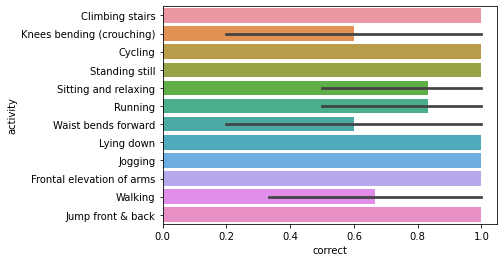

time: 761 ms


In [231]:
model = best[1].best_estimator_
y_pred = model.predict(X_test.iloc[:, best[2]])
print("Score: {:.2f}".format(best[0]))
show_result(y_pred, y_test)

Score: 0.83


alt.FacetChart(...)

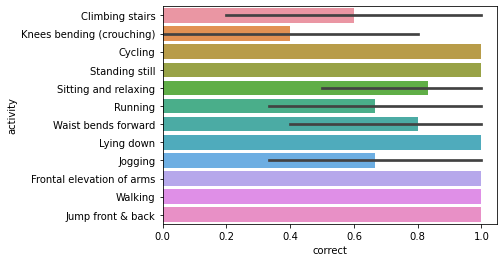

time: 9.66 s


In [259]:
params = {
            'C': np.arange(0.25, 14, 0.25),
            'kernel': ['poly', 'rbf', 'linear'],
            'degree': np.arange(1, 6, 1)
        }

clf = GridSearchCV(SVC(), params, n_jobs=5, 
               cv=StratifiedKFold(random_state=42, shuffle=True), 
               verbose=0, refit=True)

scaler = StandardScaler()
clf.fit(scaler.fit_transform(X_train), y_train)
y_pred = clf.predict(scaler.fit_transform(X_test))
score = accuracy_score(y_pred, y_test)
print("Score: {:.2f}".format(score))
show_result(y_pred, y_test)

In [238]:
best_params = {'C': 13, 'degree': 2, 'kernel': 'poly'}

time: 275 µs


## Accelerometer and ECG classifiers fusion

In [239]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

time: 300 µs


In [241]:
feature_by_importance = list(range(ecg_features_df.shape[1]-1))

features = [feature_by_importance]
scores = []

while len(feature_by_importance) > 3:
    data = pd.concat([ accel_features_df.iloc[:, :-1], ecg_features_df.iloc[:, feature_by_importance + [-1]] ], axis=1)

    X = data.drop(columns=['activity'])
    y = data['activity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    kf = KFold(5, random_state=42, shuffle=True)
    accuracies = []
    feature_importances = None
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]


        model_accel = SVC(**best_params)
        scaler2 = StandardScaler()
        model_accel.fit(scaler2.fit_transform(X_cur_train.iloc[:, :27]), y_cur_train)
        y_pred_test = model_accel.predict(scaler2.transform(X_val.iloc[:, :27]))
        y_pred_train = model_accel.predict(scaler2.transform(X_cur_train.iloc[:, :27]))

        params = {
                'min_child_weight': [1, 5, 10],
                'gamma': [0.5, 1, 1.5, 2, 5],
                'max_depth': [3, 4, 5],
                }

        clf_ecg = GridSearchCV(XGBClassifier(), params, n_jobs=5, 
                       cv=StratifiedKFold(random_state=42, shuffle=True), 
                       verbose=0, refit=True)

        pca = PCA(n_components=X_cur_train.shape[1]-28)
        scaler = StandardScaler()
        pca_comps_train = pca.fit_transform(scaler.fit_transform(X_cur_train.iloc[:, 27:]))
        clf_ecg.fit(np.hstack([pca_comps_train, y_pred_train.reshape(-1, 1)]), y_cur_train)

        if feature_importances is None:
            feature_importances = np.array(clf_ecg.best_estimator_.feature_importances_)
        else:
            feature_importances += np.array(clf_ecg.best_estimator_.feature_importances_)

        pca_comps_val = pca.transform(scaler.transform(X_val.iloc[:, 27:]))
        y_pred = clf_ecg.predict(np.hstack([pca_comps_val, y_pred_test.reshape(-1, 1)]))
        l_score = accuracy_score(y_pred, y_val)
        accuracies.append(l_score)
    scores.append(np.mean(accuracies))
    feature_by_importance = list(map(lambda x: x[1], sorted(zip(feature_importances, range(X_cur_train.shape[1]-28)), reverse=True)))[:-1]
    features.append(feature_by_importance)
    print("Score: {:.2f}".format(scores[-1]))

Score: 0.84
Score: 0.84
Score: 0.85
Score: 0.83
Score: 0.84
Score: 0.83
Score: 0.85
Score: 0.83
Score: 0.85
Score: 0.86
Score: 0.85
Score: 0.86
Score: 0.86
Score: 0.85
Score: 0.84
Score: 0.83
Score: 0.85
Score: 0.86
time: 51min 42s


In [242]:
feature_set = features[11]
data = pd.concat([ accel_features_df.iloc[:, :-1], ecg_features_df.iloc[:, feature_set + [-1]] ], axis=1)

X = data.drop(columns=['activity'])
y = data['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

kf = KFold(5, random_state=42, shuffle=True)
for i in range(1, min(5, len(feature_set))):
    accuracies = []
    feature_importances = None
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]


        model_accel = SVC(**best_params)
        scaler2 = StandardScaler()
        model_accel.fit(scaler2.fit_transform(X_cur_train.iloc[:, :27]), y_cur_train)
        y_pred_test = model_accel.predict(scaler2.transform(X_val.iloc[:, :27]))
        y_pred_train = model_accel.predict(scaler2.transform(X_cur_train.iloc[:, :27]))

        params = {
                'min_child_weight': [1, 5, 10],
                'gamma': [0.5, 1, 1.5, 2, 5],
                'max_depth': [3, 4, 5],
                }

        clf_ecg = GridSearchCV(XGBClassifier(), params, n_jobs=5, 
                       cv=StratifiedKFold(random_state=42, shuffle=True), 
                       verbose=0, refit=True)

        pca = PCA(n_components=i)
        scaler = StandardScaler()
        pca_comps_train = pca.fit_transform(scaler.fit_transform(X_cur_train.iloc[:, 27:]))
        clf_ecg.fit(np.hstack([pca_comps_train, y_pred_train.reshape(-1, 1)]), y_cur_train)

        if feature_importances is None:
            feature_importances = np.array(clf_ecg.best_estimator_.feature_importances_)
        else:
            feature_importances += np.array(clf_ecg.best_estimator_.feature_importances_)

        pca_comps_val = pca.transform(scaler.transform(X_val.iloc[:, 27:]))
        y_pred = clf_ecg.predict(np.hstack([pca_comps_val, y_pred_test.reshape(-1, 1)]))
        l_score = accuracy_score(y_pred, y_val)
        accuracies.append(l_score)
    print("Score: {:.2f} with {} features and {} components".format(np.mean(accuracies), len(feature_set), i))

Score: 0.86 with 10 features and 1 components
Score: 0.86 with 10 features and 2 components
Score: 0.86 with 10 features and 3 components
Score: 0.86 with 10 features and 4 components
time: 6min 28s


Score: 0.88


alt.FacetChart(...)

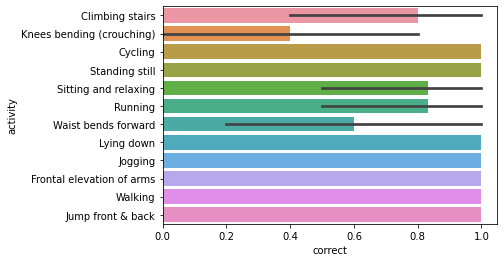

time: 7.79 s


In [257]:
feature_set = features[11]
data = pd.concat([ accel_features_df.iloc[:, :-1], ecg_features_df.iloc[:, feature_set + [-1]] ], axis=1)

X = data.drop(columns=['activity'])
y = data['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

model_accel = SVC(**best_params)
scaler2 = StandardScaler()
model_accel.fit(scaler2.fit_transform(X_train.iloc[:, :27]), y_train)
y_pred_train = model_accel.predict(scaler2.transform(X_train.iloc[:, :27]))
y_pred_test = model_accel.predict(scaler2.transform(X_test.iloc[:, :27]))

clf_ecg = GridSearchCV(XGBClassifier(), params, n_jobs=5, 
               cv=StratifiedKFold(random_state=42, shuffle=True), 
               verbose=0, refit=True)

pca = PCA(n_components=1)
scaler = StandardScaler()
pca_comps_train = pca.fit_transform(scaler.fit_transform(X_train.iloc[:, 27:]))
clf_ecg.fit(np.hstack([pca_comps_train, y_pred_train.reshape(-1, 1)]), y_train)

pca_comps_test = pca.transform(scaler.transform(X_test.iloc[:, 27:]))
y_pred = clf_ecg.predict(np.hstack([pca_comps_test, y_pred_test.reshape(-1, 1)]))
score = accuracy_score(y_pred, y_test)

print("Score: {:.2f}".format(score))
show_result(y_pred, y_test)